## Introduction

Facility Location Problems (FLPs) are classical optimization tasks. They aim at determining the best among potential sites for warehouses or factories.

Warehouses may or may not have a limited capacity. This distinguishes the capacitated (CFLP) from the uncapacitated (UFLP) variants of the problem.

The business goal to find the set of warehouse locations that minimize the costs. The original problem definition by Balinski (1965) minimizes the sum of two (annual) cost voices:

Transportation costs
Warehouse fixed costs
Transportation costs account for the expenses generated by reaching customers from the warehouse location. The warehouse fixed cost is location-specific. It may include, for instance, voices such as rent, taxes, electricity and maintenance.

Facility location is a well known subject and has a fairly rich literature. As such, many variants of the problem exist, as well as approaches. This post introduces the classical CFLP formulation and shares a practical Python example with PuLP.

## Problem Statement

The goal of CFLP is to determine the number and location of warehouses that will meet the customers demand while reducing fixed and transportation costs. Therefore, we can pose the problem as the minimization of the following objective function:

$$  \sum^{M}_{j=1} {f_j \cdot y_j} + \sum^{N}_{i=1}\sum^{M}_{j=1}t_{ij} \cdot x_{ij} $$

Where,

- $N$ is a set of customer locations.
- $M$ is a set of candidate warehouse locations.
- $f_j$ represent the annual fixed cost for warehouse $j$.
- $t_{ij}$ represents the cost of transportation from warehouse $j$ to customer $i$.
- $x_{ij}$ is the number of units delivered from warehouse $j$ to customer $i$.
- $y_j$ is a binary variable $y_j \in \{0,1\}$, indicating whether the warehouse should be built in the location $j$ $(y_j = 1)$ or not $(y_j = 0)$.


Let us now consider the addition of constraints to the objective function.

Since we are modeling a capacitated problem, each facility j can supply an annual maximum capacity $C_j$. Therefore, the number of units delivered to a customer $x_{ij}$ cannot be greater than this value:

$$ \sum^{N}_{i=1} x_{ij} \leq C_{j} \cdot y_j $$

The yearly units delivered from warehouse $j$ to customer $i$ must range between zero and $d_i$, the annual demand from customer $i$:

$$ 0 \leq x_{ij} \leq d_i \cdot y_j $$

And last but not least, we must meet customers’ demand. In this example, we impose that each warehouse serving a customer location must fully meet its demand:

$$ \sum^{M}_{j=1} x_{ij} = d_i$$



In conclusion, we can define the problem as follows:

$minimize$ $$  \sum^{M}_{j=1} {f_j \cdot y_j} + \sum^{N}_{i=1}\sum^{M}_{j=1}t_{ij} \cdot x_{ij} $$

$\text{subject to:}$
$$ \sum^{M}_{j=1} x_{ij} = d_i$$

$$ \sum^{N}_{i=1} x_{ij} \leq C_{j} \cdot y_j $$

$$ 0 \leq x_{ij} \leq d_i \cdot y_j $$

$$ y_j \in \{0, 1\} $$



In [1]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians
from shapely.geometry import Point

from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, LpStatus, value, PULP_CBC_CMD

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load Data

In [2]:
uscities_data = pd.read_csv("data/uscities.csv")
uscities_data = uscities_data[uscities_data['military']==False]
uscities_data

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18908608,11080.3,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,11922389,3184.7,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8497759,4614.5,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6080145,4758.9,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Houston,Houston,TX,Texas,48201,Harris,29.7860,-95.3885,5970127,1384.0,shape,False,True,America/Chicago,1,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31115,Kohatk,Kohatk,AZ,Arizona,4021,Pinal,32.5781,-112.0032,0,77.3,shape,False,False,America/Phoenix,3,85634,1840022983
31116,Ironville,Ironville,PA,Pennsylvania,42013,Blair,40.6586,-78.2155,0,59.2,shape,False,False,America/New_York,3,16686,1840152922
31117,Newkirk,Newkirk,NM,New Mexico,35019,Guadalupe,35.0635,-104.2715,0,0.0,shape,False,False,America/Denver,3,88417,1840024978
31118,Falcon Village,Falcon Village,TX,Texas,48427,Starr,26.5652,-99.1341,0,38.9,shape,False,False,America/Chicago,3,78545,1840018314


## Data Preprocessing

### Columns

We are interested in the following columns:

- city: name of the town;
- lat: latitude;
- lng: longitude;
- population: number of inhabitants;
- capital: indicates whether the city is a chief town or administrative center;
- state_name: name of the state
- county_name: name of the county

In [3]:
uscities_data.columns

Index(['city', 'city_ascii', 'state_id', 'state_name', 'county_fips',
       'county_name', 'lat', 'lng', 'population', 'density', 'source',
       'military', 'incorporated', 'timezone', 'ranking', 'zips', 'id'],
      dtype='object')

In [4]:
uscities_data[uscities_data['ranking']<=2]


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18908608,11080.3,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,11922389,3184.7,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8497759,4614.5,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6080145,4758.9,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Houston,Houston,TX,Texas,48201,Harris,29.7860,-95.3885,5970127,1384.0,shape,False,True,America/Chicago,1,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26321,Meadowview Estates,Meadowview Estates,KY,Kentucky,21111,Jefferson,38.2227,-85.6353,149,2016.8,shape,False,True,America/New_York,2,40220,1840015193
26485,Lazy Lake,Lazy Lake,FL,Florida,12011,Broward,26.1563,-80.1452,143,3559.2,shape,False,True,America/New_York,2,33305,1840028718
26583,Sycamore,Sycamore,KY,Kentucky,21111,Jefferson,38.2468,-85.5612,140,2467.7,shape,False,True,America/New_York,2,40223,1840030809
28962,Smith Village,Smith Village,OK,Oklahoma,40109,Oklahoma,35.4508,-97.4570,60,2118.6,shape,False,True,America/Chicago,2,73115,1840022733


In [5]:
exclude_columns=['city_ascii', 'state_id', 'county_fips', 'density', 'source','military', 'incorporated', 'timezone', 'zips', 'id']
uscities_data.drop(exclude_columns, axis=1, inplace=True)
uscities_data


,city,state_name,county_name,lat,lng,population,ranking
0,New York,New York,Queens,40.6943,-73.9249,18908608,1
1,Los Angeles,California,Los Angeles,34.1141,-118.4068,11922389,1
2,Chicago,Illinois,Cook,41.8375,-87.6866,8497759,1
3,Miami,Florida,Miami-Dade,25.7840,-80.2101,6080145,1
4,Houston,Texas,Harris,29.7860,-95.3885,5970127,1
...,...,...,...,...,...,...,...
31115,Kohatk,Arizona,Pinal,32.5781,-112.0032,0,3
31116,Ironville,Pennsylvania,Blair,40.6586,-78.2155,0,3
31117,Newkirk,New Mexico,Guadalupe,35.0635,-104.2715,0,3
31118,Falcon Village,Texas,Starr,26.5652,-99.1341,0,3


In [6]:
uscities_data = uscities_data[uscities_data['population']>0]
uscities_data

,city,state_name,county_name,lat,lng,population,ranking
0,New York,New York,Queens,40.6943,-73.9249,18908608,1
1,Los Angeles,California,Los Angeles,34.1141,-118.4068,11922389,1
2,Chicago,Illinois,Cook,41.8375,-87.6866,8497759,1
3,Miami,Florida,Miami-Dade,25.7840,-80.2101,6080145,1
4,Houston,Texas,Harris,29.7860,-95.3885,5970127,1
...,...,...,...,...,...,...,...
30674,Goldcreek,Montana,Powell,46.5838,-112.9284,1,3
30675,Stotesbury,Missouri,Vernon,37.9744,-94.5645,1,3
30676,Kelly,Kansas,Nemaha,39.7368,-96.0008,1,3
30677,Arlington,Wyoming,Carbon,41.6053,-106.1997,1,3


In [7]:
uscities_data['state_name'].unique()

array(['New York', 'California', 'Illinois', 'Florida', 'Texas',
       'Pennsylvania', 'Georgia', 'District of Columbia', 'Massachusetts',
       'Arizona', 'Michigan', 'Washington', 'Minnesota', 'Colorado',
       'Nevada', 'Maryland', 'Missouri', 'Oregon', 'Puerto Rico',
       'Indiana', 'Ohio', 'Virginia', 'North Carolina', 'Wisconsin',
       'Rhode Island', 'Tennessee', 'Utah', 'Oklahoma', 'Connecticut',
       'Kentucky', 'Louisiana', 'Nebraska', 'Alabama', 'New Mexico',
       'South Carolina', 'Iowa', 'Kansas', 'Arkansas', 'Idaho',
       'New Jersey', 'Hawaii', 'Mississippi', 'Alaska', 'New Hampshire',
       'North Dakota', 'Maine', 'South Dakota', 'West Virginia',
       'Montana', 'Delaware', 'Vermont', 'Wyoming'], dtype=object)

In [8]:
uscities_data = uscities_data[uscities_data['state_name'].isin(['California','Oregon','Washington'])]
uscities_data

,city,state_name,county_name,lat,lng,population,ranking
1,Los Angeles,California,Los Angeles,34.1141,-118.4068,11922389,1
12,Seattle,Washington,King,47.6211,-122.3244,3561397,1
13,San Francisco,California,San Francisco,37.7558,-122.4449,3364979,1
14,San Diego,California,San Diego,32.8313,-117.1222,3046560,1
20,Riverside,California,Riverside,33.9381,-117.3949,2332836,1
...,...,...,...,...,...,...,...
30552,Moss Landing,California,Monterey,36.8019,-121.7872,9,3
30572,Salmon Creek,California,Sonoma,38.3462,-123.0595,8,3
30583,Sugarloaf Village,California,Tulare,35.8269,-118.6354,7,3
30609,Whitley Gardens,California,San Luis Obispo,35.6574,-120.5070,6,3


### Customers, warehouses and demand

When creating customers, facility and demand, we assume that:
- Customers are a fraction (30%) of the input cities.
- Facilities can be established only in cities with Ranking $\geq$ 3. As a starting condition, we assume we could build warehouses in 10% of the important cities.
- Demand is constant and known through the year. It is equal to a fraction (2%) of the population of the customers’ towns plus an error term.

In [9]:
region_list = list(uscities_data['county_name'].unique())


In [10]:
random_state = 2
fraction_customer = 0.05
fraction_warehouse = 0.4
fraction_demand = 0.30

uscities_data['demand'] = np.floor(fraction_demand * uscities_data.population + np.random.uniform(-1, 1, size=(uscities_data.shape[0],)))

facility_df = uscities_data.loc[uscities_data.county_name.isin(region_list)].loc[uscities_data.ranking <=2].sample(frac=fraction_warehouse, random_state=random_state, ignore_index=True)

customer_df = uscities_data.loc[uscities_data.county_name.isin(region_list)].loc[uscities_data.ranking <=3].sample(frac=fraction_customer, random_state=random_state, ignore_index=True)
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])



/var/folders/9s/5vl8qm5n629_ld9lvn25vm2c0000gn/T/ipykernel_10576/3522073423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uscities_data['demand'] = np.floor(fraction_demand * uscities_data.population + np.random.uniform(-1, 1, size=(uscities_data.shape[0],)))


In [11]:
facility_df

,city,state_name,county_name,lat,lng,population,ranking,demand
0,Hayesville,Oregon,Marion,44.9793,-122.9738,21822,2,6545.0
1,South Pasadena,California,Los Angeles,34.1103,-118.1573,26583,2,7974.0
2,Jurupa Valley,California,Riverside,34.0010,-117.4706,105672,2,31701.0
3,Alderwood Manor,Washington,Snohomish,47.8146,-122.2672,10525,2,3157.0
4,San Jose,California,Santa Clara,37.3012,-121.8480,1771413,1,531423.0
...,...,...,...,...,...,...,...,...
125,Victorville,California,San Bernardino,34.5277,-117.3536,364015,2,109205.0
126,Murrieta,California,Riverside,33.5719,-117.1909,111899,2,33570.0
127,Alto,California,Marin,37.9056,-122.5186,659,2,197.0
128,Rohnert Park,California,Sonoma,38.3479,-122.6965,44461,2,13338.0


In [12]:
customer_df

,city,state_name,county_name,lat,lng,population,ranking,demand,customer_id
0,Belmont,California,San Mateo,37.5154,-122.2953,27820,2,8346.0,1
1,John Day,Oregon,Grant,44.4181,-118.9563,1561,3,468.0,2
2,Markleeville,California,Alpine,38.6840,-119.8228,163,3,48.0,3
3,Courtland,California,Sacramento,38.3329,-121.5570,654,3,196.0,4
4,Tustin,California,Orange,33.7311,-117.8107,79514,2,23854.0,5
...,...,...,...,...,...,...,...,...,...
119,North Edwards,California,Kern,35.0474,-117.8093,1086,3,326.0,120
120,Camp Sherman,Oregon,Jefferson,44.4493,-121.6496,313,3,93.0,121
121,Anatone,Washington,Asotin,46.1354,-117.1322,9,3,3.0,122
122,Lewisville,Washington,Clark,45.8128,-122.5143,2474,3,741.0,123


In [13]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
facility_df = add_geocoordinates(facility_df)

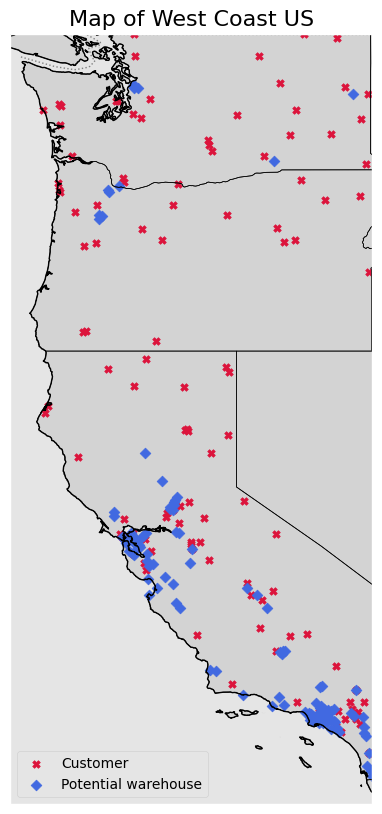

In [14]:
# Create the plot with PlateCarree projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([-125, -117, 32, 49])  

# Add land, lakes, and rivers
ax.add_feature(cfeature.LAND, facecolor='lightgray')  
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

# Plot customer and facility locations
customer_df.plot(
    ax=ax, marker='X', color='crimson', markersize=30, alpha=1, label='Customer'
)

facility_df.plot(
    ax=ax, marker='D', color='royalblue', markersize=30, alpha=1, label='Potential warehouse'
)

# Title and legend
plt.title("Map of West Coast US", fontsize=16)
plt.legend()

# Show the plot
plt.show()

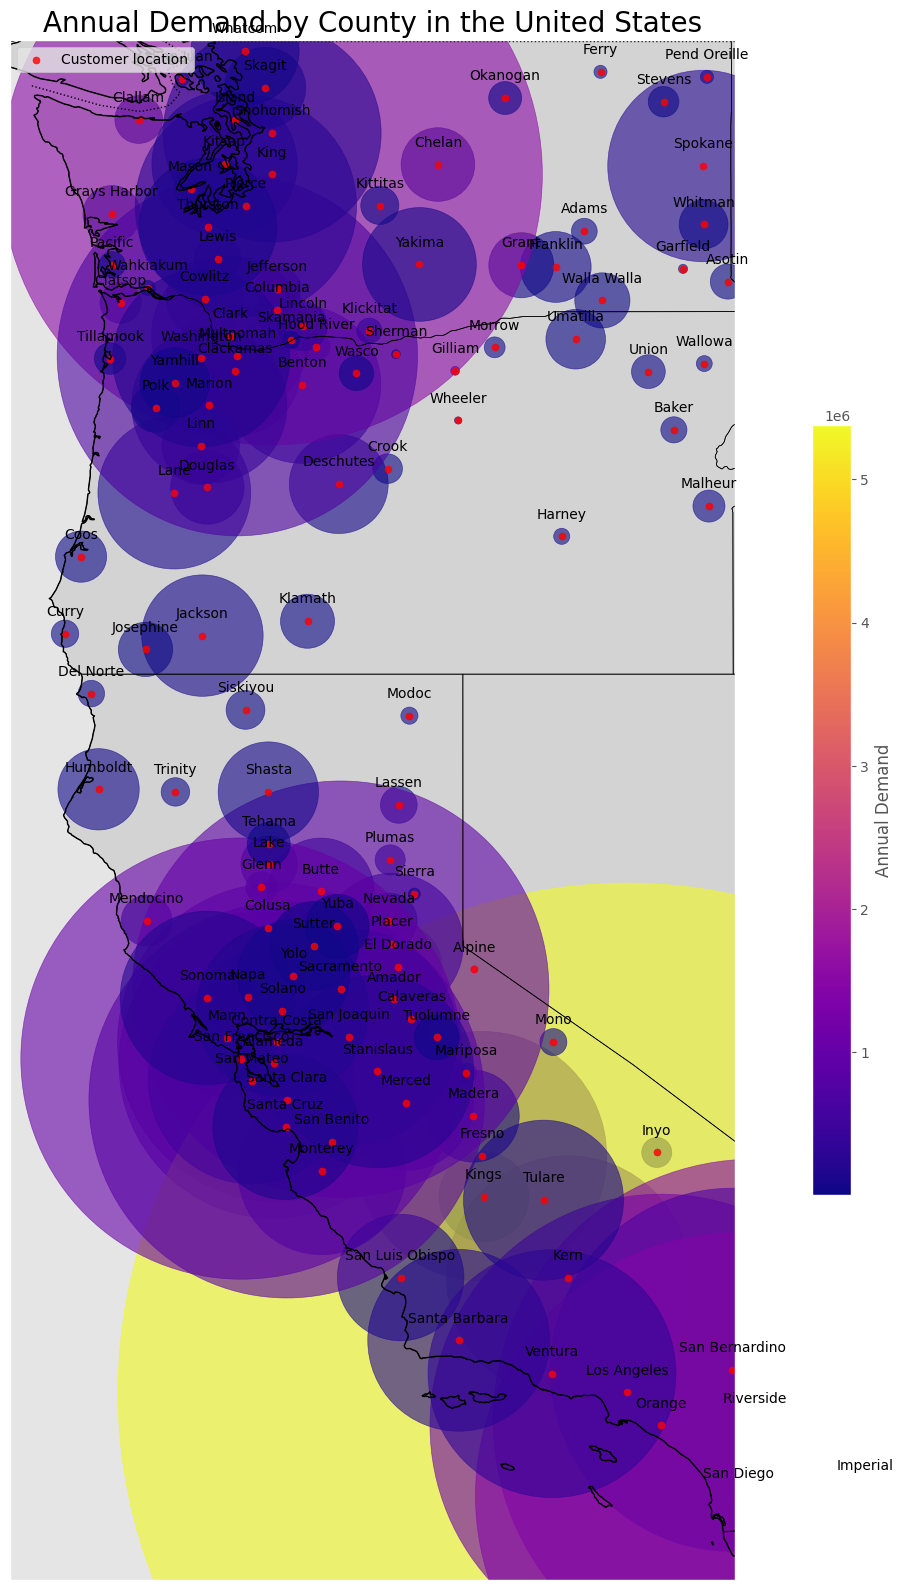

In [15]:
region_df = uscities_data.\
             loc[uscities_data.county_name.isin(region_list)].\
             groupby(['county_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

region_df = add_geocoordinates(region_df)

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([-125, -117, 32, 49])   # California longitude and latitude bounds


ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')  

region_df.plot(
    ax=ax,
    column='demand',
    cmap='plasma',
    markersize=region_df['demand'] * 0.1,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': "Annual Demand", 'shrink': 0.5},
)

region_df.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=25,
    alpha=0.8,
    label='Customer location'
)

for i, row in region_df.iterrows():
    plt.annotate(
        row.county_name, 
        xy=(row.lng, row.lat + 0.2), 
        horizontalalignment='center',
        fontsize=10,
    )

plt.title('Annual Demand by County in the United States', fontsize=20)
plt.legend()

ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [16]:
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }
demand_dict

{1: 8346.0,
 2: 468.0,
 3: 48.0,
 4: 196.0,
 5: 23854.0,
 6: 2487.0,
 7: 91.0,
 8: 20.0,
 9: 316.0,
 10: 21.0,
 11: 2044.0,
 12: 7952.0,
 13: 310.0,
 14: 44948.0,
 15: 215.0,
 16: 29.0,
 17: 178.0,
 18: 2237.0,
 19: 760.0,
 20: 802.0,
 21: 24448.0,
 22: 425.0,
 23: 197.0,
 24: 23738.0,
 25: 165.0,
 26: 42.0,
 27: 1182.0,
 28: 340.0,
 29: 109205.0,
 30: 418.0,
 31: 1005.0,
 32: 185.0,
 33: 3057.0,
 34: 3719.0,
 35: 276.0,
 36: 136.0,
 37: 1650.0,
 38: 9350.0,
 39: 59.0,
 40: 983.0,
 41: 14997.0,
 42: 652.0,
 43: 76.0,
 44: 1453.0,
 45: 43.0,
 46: 667.0,
 47: 124.0,
 48: 961.0,
 49: 161.0,
 50: 606.0,
 51: 713.0,
 52: 2622.0,
 53: 157.0,
 54: 47.0,
 55: 147.0,
 56: 159.0,
 57: 17928.0,
 58: 7954.0,
 59: 3608.0,
 60: 28823.0,
 61: 220.0,
 62: 10.0,
 63: 263.0,
 64: 126.0,
 65: 1370.0,
 66: 12.0,
 67: 4307.0,
 68: 4745.0,
 69: 214.0,
 70: 131347.0,
 71: 242.0,
 72: 3740.0,
 73: 632.0,
 74: 61.0,
 75: 1750.0,
 76: 5213.0,
 77: 70.0,
 78: 970.0,
 79: 602.0,
 80: 527.0,
 81: 412.0,
 82: 57.0,

### Supply and fixed costs

To model supply and fixed costs, we assume that:

- Each warehouse can meet a maximum yearly supply equal to 3 times the average regional demand.
- Each warehouse has a constant annual fixed cost of $ \$100,000.00 $ , independently from its location.
- As we did for the demand, we store supply and fixes costs in dictionaries:

In [17]:
cost_per_warehouse = 300000
supply_factor_per_warehouse = 3
supply_per_warehouse = region_df.demand.mean() * supply_factor_per_warehouse

facility_df['warehouse_id'] = ['Warehouse ' + str(i) for i in range(1, 1 + facility_df.shape[0])]

annual_supply_dict = { warehouse : supply_per_warehouse for warehouse in facility_df['warehouse_id'] }

annual_cost_dict = { warehouse : cost_per_warehouse for warehouse in facility_df['warehouse_id'] }

In [18]:
annual_supply_dict

{'Warehouse 1': 520235.3095238096,
 'Warehouse 2': 520235.3095238096,
 'Warehouse 3': 520235.3095238096,
 'Warehouse 4': 520235.3095238096,
 'Warehouse 5': 520235.3095238096,
 'Warehouse 6': 520235.3095238096,
 'Warehouse 7': 520235.3095238096,
 'Warehouse 8': 520235.3095238096,
 'Warehouse 9': 520235.3095238096,
 'Warehouse 10': 520235.3095238096,
 'Warehouse 11': 520235.3095238096,
 'Warehouse 12': 520235.3095238096,
 'Warehouse 13': 520235.3095238096,
 'Warehouse 14': 520235.3095238096,
 'Warehouse 15': 520235.3095238096,
 'Warehouse 16': 520235.3095238096,
 'Warehouse 17': 520235.3095238096,
 'Warehouse 18': 520235.3095238096,
 'Warehouse 19': 520235.3095238096,
 'Warehouse 20': 520235.3095238096,
 'Warehouse 21': 520235.3095238096,
 'Warehouse 22': 520235.3095238096,
 'Warehouse 23': 520235.3095238096,
 'Warehouse 24': 520235.3095238096,
 'Warehouse 25': 520235.3095238096,
 'Warehouse 26': 520235.3095238096,
 'Warehouse 27': 520235.3095238096,
 'Warehouse 28': 520235.3095238096,
 

In [19]:
annual_cost_dict

{'Warehouse 1': 300000,
 'Warehouse 2': 300000,
 'Warehouse 3': 300000,
 'Warehouse 4': 300000,
 'Warehouse 5': 300000,
 'Warehouse 6': 300000,
 'Warehouse 7': 300000,
 'Warehouse 8': 300000,
 'Warehouse 9': 300000,
 'Warehouse 10': 300000,
 'Warehouse 11': 300000,
 'Warehouse 12': 300000,
 'Warehouse 13': 300000,
 'Warehouse 14': 300000,
 'Warehouse 15': 300000,
 'Warehouse 16': 300000,
 'Warehouse 17': 300000,
 'Warehouse 18': 300000,
 'Warehouse 19': 300000,
 'Warehouse 20': 300000,
 'Warehouse 21': 300000,
 'Warehouse 22': 300000,
 'Warehouse 23': 300000,
 'Warehouse 24': 300000,
 'Warehouse 25': 300000,
 'Warehouse 26': 300000,
 'Warehouse 27': 300000,
 'Warehouse 28': 300000,
 'Warehouse 29': 300000,
 'Warehouse 30': 300000,
 'Warehouse 31': 300000,
 'Warehouse 32': 300000,
 'Warehouse 33': 300000,
 'Warehouse 34': 300000,
 'Warehouse 35': 300000,
 'Warehouse 36': 300000,
 'Warehouse 37': 300000,
 'Warehouse 38': 300000,
 'Warehouse 39': 300000,
 'Warehouse 40': 300000,
 'Warehou

### Transportation costs

The estimate of transportation costs requires:

- the distance between the different locations, and
- a cost function per unit of distance.
- We can approximate the distance between two locations on a spherical surface using the Haversine formula:

In [20]:
from geopy.distance import geodesic


### Test

For testing purpose i have considered the Yonkers,NY and New York City, NY

In actual, considering car navigation in map

<img src="map.png" width=400 height=300></img>

In [21]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in miles
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    # Earth's radius in miles
    earth_radius_miles = 3958.76
    
    return earth_radius_miles *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

In [22]:
haversine_distance(40.9466,-73.8673,40.6943,-73.9249)

17.690516816116613

In [23]:
geodesic((40.9466,-73.8673), (40.6943,-73.9249)).miles

17.669491284213233

To modify the function for miles, we need to adjust the calculation to account for the distance in miles. Here's how it looks with the necessary conversion:

1. Average price of gasoline in the US (example): **\$3.50 per gallon** (you can adjust this based on updated data).
2. Average truck fuel efficiency: **6 miles per gallon** (example; you can refine this estimate).
3. Cost per mile:
  $$
   \text{Cost per mile} = \frac{\text{Price per gallon}}{\text{Miles per gallon}}
  $$

In [24]:
def traveling_cost(distance_in_miles):
    return 1.5 * distance_in_miles

In [25]:
transport_costs_dict = {}

for i in range(0, facility_df.shape[0]):
    
    warehouse_transport_costs_dict = {}
    
    for j in range(0, customer_df.shape[0]):
        
        d = 0 if facility_df.city[i]==customer_df.city[j] else geodesic(
            (facility_df.lat[i], facility_df.lng[i]), (customer_df.lat[j], customer_df.lng[j])).miles
        
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost(d)})
    
    transport_costs_dict.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})
transport_costs_dict

{'Warehouse 1': {1: 774.4200049587934,
  2: 302.3926864410894,
  3: 695.7281637599624,
  4: 696.7425416441422,
  5: 1234.9602558414467,
  6: 1246.0115519428596,
  7: 688.0968538458475,
  8: 118.50487629850113,
  9: 362.74064694464573,
  10: 265.1669415328524,
  11: 902.6813081516866,
  12: 1378.2054109952264,
  13: 918.914877575819,
  14: 1204.1340412565157,
  15: 319.4126894474247,
  16: 1014.1215462129899,
  17: 786.3435209310496,
  18: 759.7851385653184,
  19: 726.9312278908715,
  20: 26.06032861175045,
  21: 1215.402787589432,
  22: 62.61921645165167,
  23: 733.1003837010078,
  24: 676.3569445142513,
  25: 550.9807162785842,
  26: 71.52822714896386,
  27: 777.4568139186749,
  28: 1161.3345170005953,
  29: 1170.3020731863405,
  30: 419.12877242823936,
  31: 236.6212096456437,
  32: 349.1808884321804,
  33: 1201.688747623415,
  34: 238.51542804335733,
  35: 769.5859282787053,
  36: 507.5312760773814,
  37: 264.40087748724983,
  38: 1251.6445393866184,
  39: 456.85310406462656,
  40: 

### Optimization

Let us remind the optimization problem:

$minimize$ $$  \sum^{M}_{j=1} {f_j \cdot y_j} + \sum^{N}_{i=1}\sum^{M}_{j=1}t_{ij} \cdot x_{ij} $$

$\text{subject to:}$
$$ \sum^{M}_{j=1} x_{ij} = d_i$$

$$ \sum^{N}_{i=1} x_{ij} \leq C_{j} \cdot y_j $$

$$ 0 \leq x_{ij} \leq d_i \cdot y_j $$

$$ y_j \in \{0, 1\} $$


In [26]:
# Define linear problem
lp_problem = LpProblem('CFLP', LpMinimize)


# Variable: y_j (constraint: it is binary)
created_facility = LpVariable.dicts(
    'Create_facility', facility_df['warehouse_id'], 0, 1, LpBinary)

# Variable: x_ij
served_customer = LpVariable.dicts(
    'Link', [(i,j) for i in customer_df['customer_id'] for j in facility_df['warehouse_id']], 0)


# Objective function 
objective = lpSum(annual_cost_dict[j]*created_facility[j] for j in facility_df['warehouse_id']) +\
            lpSum(transport_costs_dict[j][i]*served_customer[(i,j)] \
                  for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])

lp_problem += objective

# Costraint: the demand must be met
for i in customer_df['customer_id']:
    lp_problem += lpSum(served_customer[(i,j)] for j in facility_df['warehouse_id']) == demand_dict[i]

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    lp_problem += lpSum(served_customer[(i,j)] for i in customer_df['customer_id']) <= annual_supply_dict[j] * created_facility[j]

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        lp_problem += served_customer[(i,j)] <= demand_dict[i] * created_facility[j]


In [27]:
# Solve the problem
lp_problem.solve(PULP_CBC_CMD(msg=1))



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jeeva/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/9s/5vl8qm5n629_ld9lvn25vm2c0000gn/T/060c87b789df41839f59435037b8d5c3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/9s/5vl8qm5n629_ld9lvn25vm2c0000gn/T/060c87b789df41839f59435037b8d5c3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16379 COLUMNS
At line 97490 RHS
At line 113865 BOUNDS
At line 113996 ENDATA
Problem MODEL has 16374 rows, 16250 columns and 64610 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.1604e+07 - 0.02 seconds
Cgl0004I processed model has 16374 rows, 16250 columns (130 integer (130 of which binary)) and 64610 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 6.66134e-16
Cbc0038I Solution found of 2.1604e+07
Cbc0038I Relaxing conti

1

In [28]:
# Print the results
print(f"Status: {LpStatus[lp_problem.status]}")
print(f"Total Cost: ${value(lp_problem.objective):,.2f}")


Status: Optimal
Total Cost: $21,604,031.40


In [29]:
total_demand = customer_df['demand'].sum()
total_capacity = sum(annual_supply_dict.values())

print(f"Total Demand: {total_demand}")
print(f"Total Capacity: {total_capacity}")

if total_demand > total_capacity:
    print("Infeasibility due to insufficient capacity!")


Total Demand: 1452636.0
Total Capacity: 67630590.23809502


In [30]:
print("Sample Transport Costs:", list(transport_costs_dict.values())[:5])
print("Sample Fixed Costs:", list(annual_cost_dict.values())[:5])

Sample Transport Costs: [{1: 774.4200049587934, 2: 302.3926864410894, 3: 695.7281637599624, 4: 696.7425416441422, 5: 1234.9602558414467, 6: 1246.0115519428596, 7: 688.0968538458475, 8: 118.50487629850113, 9: 362.74064694464573, 10: 265.1669415328524, 11: 902.6813081516866, 12: 1378.2054109952264, 13: 918.914877575819, 14: 1204.1340412565157, 15: 319.4126894474247, 16: 1014.1215462129899, 17: 786.3435209310496, 18: 759.7851385653184, 19: 726.9312278908715, 20: 26.06032861175045, 21: 1215.402787589432, 22: 62.61921645165167, 23: 733.1003837010078, 24: 676.3569445142513, 25: 550.9807162785842, 26: 71.52822714896386, 27: 777.4568139186749, 28: 1161.3345170005953, 29: 1170.3020731863405, 30: 419.12877242823936, 31: 236.6212096456437, 32: 349.1808884321804, 33: 1201.688747623415, 34: 238.51542804335733, 35: 769.5859282787053, 36: 507.5312760773814, 37: 264.40087748724983, 38: 1251.6445393866184, 39: 456.85310406462656, 40: 266.68963339594546, 41: 683.3734992908733, 42: 419.50607751254745, 43

In [31]:

# Display warehouse and customer assignments
for j in facility_df['warehouse_id']:
    if created_facility[j].value() == 1:
        print(f"Warehouse {j} is opened.")
        for i in customer_df['customer_id']:
            if served_customer[(i, j)].value() > 0:
                print(f"  - Serves Customer {i} with {served_customer[(i, j)].value()} units.")

Warehouse Warehouse 3 is opened.
  - Serves Customer 6 with 2487.0 units.
  - Serves Customer 53 with 157.0 units.
  - Serves Customer 76 with 5213.0 units.
  - Serves Customer 78 with 970.0 units.
  - Serves Customer 97 with 179741.69 units.
  - Serves Customer 99 with 3931.0 units.
  - Serves Customer 108 with 62784.0 units.
Warehouse Warehouse 4 is opened.
  - Serves Customer 10 with 21.0 units.
  - Serves Customer 30 with 418.0 units.
  - Serves Customer 34 with 3719.0 units.
  - Serves Customer 37 with 1650.0 units.
  - Serves Customer 44 with 1453.0 units.
  - Serves Customer 50 with 606.0 units.
  - Serves Customer 52 with 2622.0 units.
  - Serves Customer 68 with 4745.0 units.
  - Serves Customer 72 with 3740.0 units.
  - Serves Customer 87 with 82.0 units.
  - Serves Customer 93 with 247.0 units.
Warehouse Warehouse 26 is opened.
  - Serves Customer 47 with 124.0 units.
  - Serves Customer 59 with 3608.0 units.
  - Serves Customer 61 with 220.0 units.
  - Serves Customer 77 wi

In [32]:
created_facility['Warehouse 1'].varValue


0.0

In [33]:
facility_values = [i.varValue for i in created_facility.values()]

[[i, facility_values.count(i)] for i in set(facility_values)]


[[0.0, 111], [1.0, 19]]

In [34]:
facility_df['build_warehouse'] = ''

for i in facility_df['warehouse_id']:
    if created_facility[i].varValue == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Warehouse 3
Build site at:  Warehouse 4
Build site at:  Warehouse 26
Build site at:  Warehouse 33
Build site at:  Warehouse 43
Build site at:  Warehouse 62
Build site at:  Warehouse 80
Build site at:  Warehouse 83
Build site at:  Warehouse 87
Build site at:  Warehouse 89
Build site at:  Warehouse 95
Build site at:  Warehouse 108
Build site at:  Warehouse 110
Build site at:  Warehouse 111
Build site at:  Warehouse 113
Build site at:  Warehouse 115
Build site at:  Warehouse 119
Build site at:  Warehouse 123
Build site at:  Warehouse 126


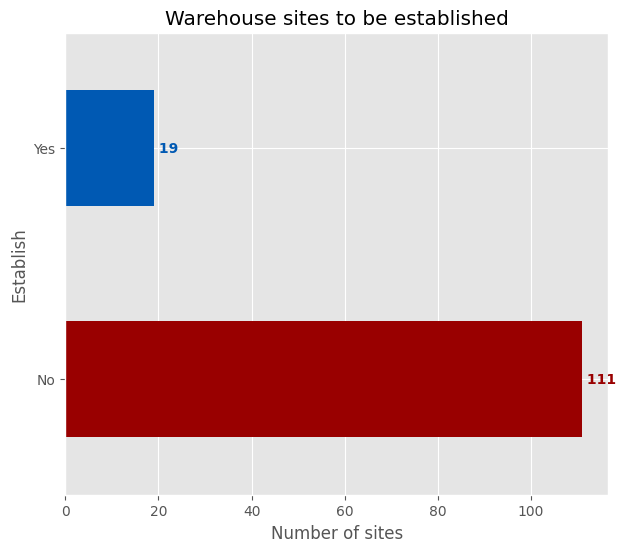

In [35]:
colors = ['#990000', '#0059b3']

facility_df.build_warehouse.value_counts().plot.barh(
  title='Warehouse sites to be established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(facility_df.build_warehouse.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')


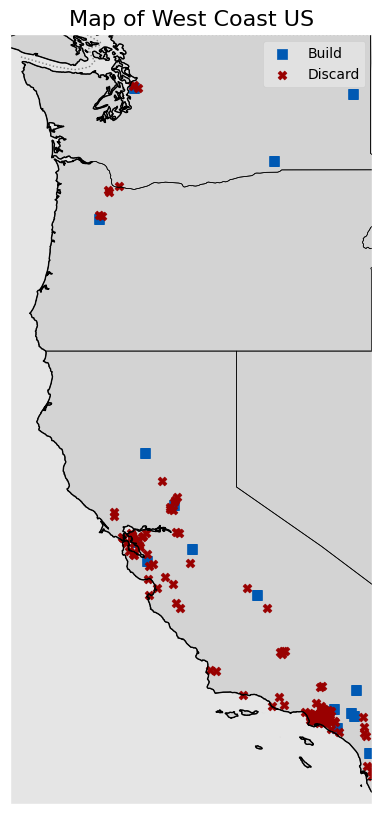

In [36]:
# Create the plot with PlateCarree projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Set the extent to focus only on California
ax.set_extent([-125, -117, 32, 49])   # California longitude and latitude bounds

# Add land, lakes, and rivers
ax.add_feature(cfeature.LAND, facecolor='lightgray')  
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

# Plot sites to establish warehouses
facility_df.loc[facility_df.build_warehouse == 'Yes'].plot(
    ax=ax, marker='s', color='#0059b3', markersize=50, label='Build'
)

# Plot sites to discard
facility_df.loc[facility_df.build_warehouse == 'No'].plot(
    ax=ax, marker='X', color='#990000', markersize=40, label='Discard'
)
# Title and legend
plt.title("Map of West Coast US", fontsize=16)
plt.legend()

# Show the plot
plt.show()

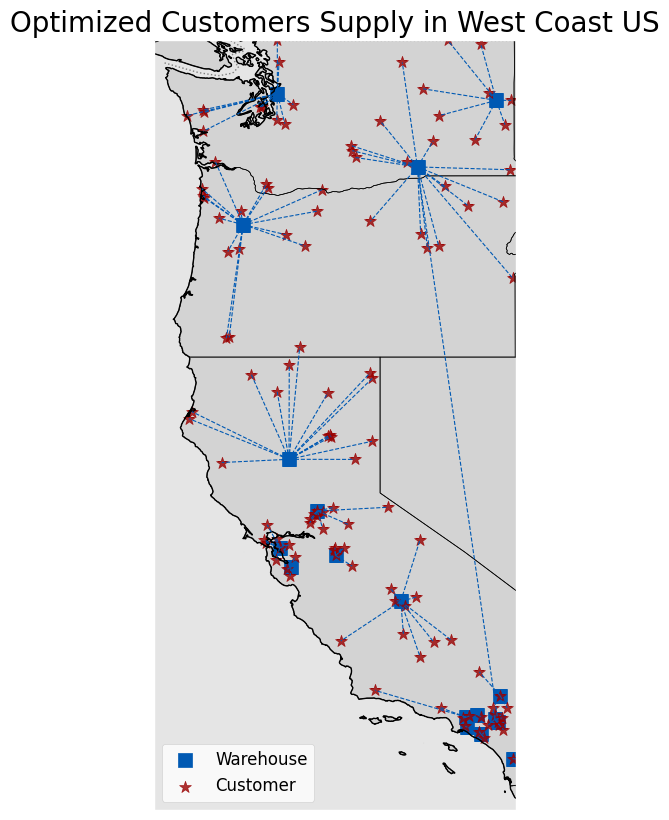

In [37]:
def get_linked_customers(input_warehouse):
    '''
    Find customer ids that are served by the input warehouse.
    
    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty list
    linked_customers = []
    
    # Iterate through the xij decision variable
    for (k, v) in served_customer.items():
        # Filter the input warehouse and positive variable values
        if k[1] == input_warehouse and v.varValue > 0:
            # Customer is served by the input warehouse
            linked_customers.append(k[0])

    return linked_customers

# Warehouses to establish
establish = facility_df.loc[facility_df.build_warehouse == 'Yes']

# Create the plot with PlateCarree projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Set the extent to focus on California's longitude and latitude bounds
ax.set_extent([-125, -117, 32, 49])  # California bounding box

# Add features to the map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

# Plot warehouses to establish
establish.plot(
    ax=ax, marker='s', color='#0059b3', markersize=100, label='Warehouse'
)

# Plot customer locations
customer_df.plot(
    ax=ax, marker='*', color='#990000', markersize=80, alpha=0.8, label='Customer'
)

# Plot connections between warehouses and customers
for w in establish.warehouse_id:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w)
    
    # For each served customer, plot the connection
    for c in linked_customers:
        ax.plot(
            [establish.loc[establish.warehouse_id == w].lng.values[0], customer_df.loc[customer_df.customer_id == c].lng.values[0]],
            [establish.loc[establish.warehouse_id == w].lat.values[0], customer_df.loc[customer_df.customer_id == c].lat.values[0]],
            linewidth=0.8, linestyle='--', color='#0059b3', transform=ccrs.PlateCarree()
        )

# Add title and legend
plt.title('Optimized Customers Supply in West Coast US', fontsize=20)
plt.legend(facecolor='white', fontsize=12)

# Show the plot
plt.show()